In [11]:
import torch
import torch.nn as nn
import torch.optim as opt
from model.sffnet import USFFNet
from utils.evaluate import Evaluate

from torch.utils.data import DataLoader, TensorDataset
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter('./logs')
from torchvision import utils as vutils
import os
import random
import pandas as pd
import numpy as np
import warnings
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [12]:
device = 'cuda:0'
batch_size = 128
stride = 1
window_size = 150

path = './datasets/SOC/0degC'
train_list = ['589_Mixed1.csv', '589_Mixed2.csv', '590_Mixed4.csv', '590_Mixed5.csv', '590_Mixed6.csv', '590_Mixed7.csv']
test_list = ['590_Mixed8.csv']

In [13]:
from utils.build_dataloader import get_dataloder
train_loader, test_loader = get_dataloder(path, window_size, stride, train_list, test_list, batch_size, device)

loading data...


100%|██████████| 1/1 [00:00<00:00,  6.45it/s]


In [14]:
test_ratio = 1
epoches = 20
weight_decay = 1e-4
learning_rate = 5e-4
loss_funcation = nn.MSELoss()
evaluater = Evaluate(path.split('/')[1], 'Ablation', test_ratio)
block_num = 5
feature_num = 3

spa_ks_list = [3, 5, 7, 7, 7]
fre_ks_list = [3, 5, 7, 7, 7]
fus_ks_list = [3, 3, 7, 7, 7]
mid_channel_list = [32, 16, 8, 4, 4]


In [15]:
import torch
import math
import torch.nn.init as init
import torch.nn as nn
import torch.fft as fft
from model.uncertainty_head import UncertaintyHead
from model.basic_module import *
from Embed import *
from torchvision import utils as vutils
import time


class SpatialFlow(nn.Module):

    def __init__(self, window_size, feature_num, mid_channel, kernel_size):
        super(SpatialFlow, self).__init__()
        padding = int(kernel_size//2)
        self.up_conv1 = nn.Conv1d(feature_num  ,feature_num*2,kernel_size,1,padding)
        self.up_conv2 = nn.Conv1d(feature_num*2,feature_num*4,kernel_size,1,padding)

        self.c_conv = nn.Conv1d(feature_num*4, feature_num*4,kernel_size,1,padding)

        self.down_conv2 = nn.Conv1d(feature_num*4,feature_num*2,kernel_size,1,padding)
        self.down_conv1 = nn.Conv1d(feature_num*2,feature_num  ,kernel_size,1,padding)
        # self.icb = ICB(feature_num,mid_channel)
        # up_sampling

        # down_sampling

        self.Spa_CNN = nn.Sequential(nn.Conv1d(feature_num, mid_channel, kernel_size, 1, padding),
                                      nn.ReLU(),
                                      nn.Conv1d(mid_channel, feature_num, kernel_size, 1, padding),
                                      )
        self.act = nn.ReLU()


    def forward(self, x):
        Spa_feature = self.Spa_CNN(x)

        return Spa_feature


class FrequencyFlow(nn.Module):

    def __init__(self, window_size, feature_num, mid_channel, kernel_size):
        super(FrequencyFlow, self).__init__()
        padding = int(kernel_size//2)
        self.pha_process = nn.Sequential(nn.Conv1d(feature_num, mid_channel, kernel_size, 1, padding), nn.ReLU(),
                                        nn.Conv1d(mid_channel, feature_num, kernel_size, 1, padding))
        self.amp_process = nn.Sequential(nn.Conv1d(feature_num, mid_channel, kernel_size, 1, padding), nn.ReLU(),
                                        nn.Conv1d(mid_channel, feature_num, kernel_size, 1, padding))

    def make_complex(self, phase, amplitude):
        real = amplitude * torch.cos(phase)
        im = amplitude * torch.sin(phase)
        complex_num = torch.complex(real, im)
        return complex_num

    def forward(self, x):
        frequency = fft.fft(x, dim=2, norm='backward')
        phase = torch.angle(frequency)
        magnitude = torch.abs(frequency)
        refine_phase = self.pha_process(phase)
        refine_magnitude = self.amp_process(magnitude)
        refine_spatial = self.make_complex(refine_phase, refine_magnitude)
        Fre_feature = torch.abs(fft.ifft(refine_spatial, dim=2, norm='backward'))
        return Fre_feature


class FusionBlock(nn.Module):

    def __init__(self, window_size, kernel_size, feature_num, r):
        super(FusionBlock, self).__init__()
        self.SA = SpatialAttention(kernel_size)
        self.CA = ChannelAttention(feature_num, r)


    def forward(self, fre_feature, spa_feature):
        spatial_refine_feature = self.SA(fre_feature - spa_feature)
        channel_refine_feature = self.CA(fre_feature + spa_feature)
        return channel_refine_feature + spatial_refine_feature

class ICB(nn.Module):
    def __init__(self, in_features, hidden_features, drop=0.7):
        super().__init__()
        self.conv1 = nn.Conv1d(in_features, hidden_features, 1)
        self.conv2 = nn.Conv1d(in_features, hidden_features, 3, 1, padding=1)
        self.conv3 = nn.Conv1d(hidden_features, in_features, 1)
        self.drop = nn.Dropout(drop)
        self.act = nn.ReLU()
        self.bn = nn.BatchNorm1d(in_features)

    def forward(self, x):
        # x = x.transpose(1, 2)
        x1 = self.conv1(x)
        x1_1 = self.act(x1)
        x1_2 = self.drop(x1_1)

        x2 = self.conv2(x)
        x2_1 = self.act(x2)
        x2_2 = self.drop(x2_1)

        out1 = x1 * x2_2
        out2 = x2 * x1_2

        out = self.conv3(out1 + out2)

        return out




class CRU(nn.Module):

    def __init__(self, window_size, kernel_size, feature_num, r):
        super(CRU, self).__init__()
        self.vc_channel = 2
        self.t_channel = 1
        ratio = 2
        self.vc_conv1   = nn.Conv1d(self.vc_channel,self.vc_channel*ratio,kernel_size)
        self.t_conv1 = nn.Conv1d(self.t_channel,self.t_channel*ratio,kernel_size)

        self.vc_conv2 =nn.Conv1d(self.vc_channel*ratio,self.vc_channel,1)
        self.t_conv2 = nn.Conv1d(self.t_channel*ratio,self.t_channel,1)

        self.vc_conv3 =nn.Conv1d(self.vc_channel*ratio,self.vc_channel,kernel_size)
        self.t_conv3 = nn.Conv1d(self.t_channel*ratio,self.t_channel,kernel_size)

    def forward(self, x):
        vc,t = torch.split(x,[self.vc_channel,self.t_channel],dim=1)
        vc = self.vc_conv(vc)
        t  = self.t_conv(t)

        vc = self.vc_conv2(vc) + self.vc_conv3(vc)
        t = self.t_conv2(t) + self.vc_conv3(t)

        feature = torch.cat([vc,t],dim=1)

        return feature + x

class PAIFILTER(nn.Module):

    def __init__(self,hidden_size,seq_len):
        super(PAIFILTER, self).__init__()
        self.seq_len = seq_len
        self.pred_len = 1
        self.scale = 0.02

        self.embed_size = self.seq_len
        self.hidden_size = hidden_size

        self.w = nn.Parameter(self.scale * torch.randn(3, self.embed_size))

        self.fc = nn.Sequential(
            nn.Linear(self.embed_size, self.hidden_size),
            nn.LeakyReLU(),
            nn.Linear(self.hidden_size, self.pred_len)
        )
        self.softmx = nn.Softmax(dim=1)


    def circular_convolution(self, x, w):
        x = torch.fft.rfft(x, dim=2, norm='ortho')
        w = torch.fft.rfft(w, dim=1, norm='ortho')
        y = x * w
        out = torch.fft.irfft(y, n=self.embed_size, dim=2, norm="ortho")
        return out

    def forward(self, x):
        x = self.circular_convolution(x, self.w.to(x.device))  # B, N, D
        x = self.fc(x)
        x = self.softmx(x)

        return x


class SFFBlock(nn.Module):

    def __init__(self, window_size, feature_num, mid_channel, spa_ks, fre_ks, fus_ks, r, fb, sf, ff):
        super(SFFBlock, self).__init__()
        self.fb, self.sf, self.ff = fb, sf, ff
        if fb is True:
            self.FB = FusionBlock(window_size, fus_ks, feature_num, r)
        if sf is True:
            self.SF = SpatialFlow(window_size, feature_num, mid_channel, spa_ks)
        if ff is True:
            self.FF = FrequencyFlow(window_size, feature_num, mid_channel, fre_ks)

        self.ffn = nn.Linear(feature_num*2,feature_num)
        self.act = nn.Sigmoid()

    def forward(self, x):

        if self.sf is True:
            Spa_feature = self.SF(x)
        if self.ff is True:
            Fre_feature = self.FF(x)
        if self.fb is True:
            # feature = Spa_feature
            # feature = Fre_feature
            # feature = Fre_feature + Spa_feature
            feature = self.ffn(torch.concat([Spa_feature , Fre_feature],dim=1).transpose(2,1)).transpose(1,2)
            # feature = self.FB(Spa_feature,Fre_feature)
            # feature = self.icb(torch.concat([Spa_feature , Fre_feature],dim=1))

        return feature+x


class USFFNet(nn.Module):

    def __init__(self, num_block, feature_num, window_size,stride, mid_channel_list, spa_ks_list, fre_ks_list, fus_ks_list):
        super(USFFNet, self).__init__()
        self.SFFBlock = nn.Sequential()
        for i in range(num_block):
             self.SFFBlock.add_module('SFFBlock'+str(i), SFFBlock(window_size, feature_num, mid_channel_list[i], spa_ks_list[i], fre_ks_list[i], fus_ks_list[i], 2, True, True, True))
        self.CNNI = nn.Sequential(nn.Conv1d(feature_num, 1, 3, 1, 1))
        self.Uncertainty_Head = UncertaintyHead(window_size,stride)
        # self.icb = ICB(feature_num, feature_num)
        self.embedding = DataEmbedding(feature_num,feature_num)

        self.paifilter = PAIFILTER(hidden_size=50,seq_len=window_size)

    def forward(self, x):

        embeded_x = self.embedding(x)
        # print(feature.shape)
        # feature, weight  = self.Adaptive_Spectral_Block(embeded_x)
        # print(feature.shape,sum(freq_mask))
        # print(feature.shape)

        weight = self.paifilter(embeded_x)

        # feature = self.SFFBlock(feature + x )
        feature = self.SFFBlock(weight * embeded_x + x)
        # feature = self.CNNI(feature)
        # feature = self.icb(feature)
        #

        feature = feature.reshape(feature.shape[0], feature.shape[1]*feature.shape[2])

        gamma, nu, alpha, beta = self.Uncertainty_Head.forward(feature)
        return gamma, nu, alpha, beta




In [16]:
model = USFFNet(block_num, feature_num, window_size,stride, mid_channel_list, spa_ks_list, fre_ks_list, fus_ks_list).to(device)

optimizer = opt.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)
evaluater.record_param_setting(window_size, stride, batch_size, learning_rate, weight_decay, model)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)


In [17]:
lambda_coef = []
train_loss = []
vaild_loss = []

In [18]:
for epoch in range(epoches):
    model.train()
    epoch_loss = 0
    print('epoch: '+str(epoch))
    for x, y in tqdm(train_loader):
        # train
        gamma, nu, alpha, beta = model.forward(x)
        loss, nig_loss, nig_regularization = model.Uncertainty_Head.get_loss(y, gamma, nu, alpha, beta)

        loss = loss_funcation(gamma, y)+loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.Uncertainty_Head.hyperparams_update(nig_regularization)
        # print(gamma.shape)
        _loss = loss_funcation(gamma, y)
        epoch_loss += _loss.item()

    epoch_loss /= train_loader.__len__()
#     writer.add_scalar("Loss/train",epoch_loss,epoch)
    lambda_coef.append(model.Uncertainty_Head.lambda_coef.detach().cpu().numpy())
    train_loss.append(epoch_loss)
    print('trainning_loss = '+str(epoch_loss))
    if epoch%test_ratio == 0:
        model.eval()
        epoch_loss = 0
        for x, y in test_loader:
            gamma, nu, alpha, beta = model.forward(x)
            gamma = torch.cat((gamma[:5], (gamma[:-5] + gamma[1:-4]  + gamma[2:-3] + gamma[3:-2] + gamma[4:-1]) / 5), dim=0)
            _loss = loss_funcation(gamma, y)
            epoch_loss += _loss.item()
        epoch_loss /= test_loader.__len__()
#         writer.add_scalar('Loss/vali',epoch_loss,epoch)

        vaild_loss.append(epoch_loss)
        print('testing_loss = '+str(epoch_loss))

    # if early_stopping.early_stop:
    #     print("Early stopping")
    #    break
    evaluater.visualize(train_loss, vaild_loss, model, None)

epoch: 0


100%|██████████| 2810/2810 [01:52<00:00, 25.01it/s]


trainning_loss = 0.0027979166089313508
testing_loss = 0.003301918380660642
Validation loss decreased (1.000000 --> 0.003302).  Saving model ...
epoch: 1


100%|██████████| 2810/2810 [00:56<00:00, 50.13it/s]


trainning_loss = 0.0012469554582844385
testing_loss = 0.008992151250080335
epoch: 2


100%|██████████| 2810/2810 [00:58<00:00, 48.22it/s]


trainning_loss = 0.0010986974646604133
testing_loss = 0.0068816681075799455
epoch: 3


100%|██████████| 2810/2810 [00:57<00:00, 48.49it/s]


trainning_loss = 0.0010045558329360076
testing_loss = 0.0045992808517563415
epoch: 4


100%|██████████| 2810/2810 [00:58<00:00, 48.16it/s]


trainning_loss = 0.000941632031293228
testing_loss = 0.006020145818013134
epoch: 5


100%|██████████| 2810/2810 [01:20<00:00, 34.76it/s]


trainning_loss = 0.0008905687518343264
testing_loss = 0.006687500915891111
epoch: 6


100%|██████████| 2810/2810 [01:24<00:00, 33.22it/s]


trainning_loss = 0.0008512032800250491
testing_loss = 0.006761962585401156
epoch: 7


100%|██████████| 2810/2810 [01:23<00:00, 33.59it/s]


trainning_loss = 0.000813767508890735
testing_loss = 0.007244040046092483
epoch: 8


100%|██████████| 2810/2810 [01:19<00:00, 35.42it/s]


trainning_loss = 0.0007852461571731436
testing_loss = 0.0071649525911572495
epoch: 9


100%|██████████| 2810/2810 [01:20<00:00, 34.96it/s]


trainning_loss = 0.000769605709250612
testing_loss = 0.008229900833516894
epoch: 10


100%|██████████| 2810/2810 [01:20<00:00, 34.90it/s]


trainning_loss = 0.0007597309325322894
testing_loss = 0.008524044084719615
epoch: 11


100%|██████████| 2810/2810 [01:20<00:00, 35.09it/s]


trainning_loss = 0.000736297329618874
testing_loss = 0.006310751009016425
epoch: 12


100%|██████████| 2810/2810 [01:19<00:00, 35.45it/s]


trainning_loss = 0.0007195621005962089
testing_loss = 0.006144575516429995
epoch: 13


100%|██████████| 2810/2810 [01:20<00:00, 34.97it/s]


trainning_loss = 0.0007079102562220927
testing_loss = 0.005649645309976764
epoch: 14


100%|██████████| 2810/2810 [01:20<00:00, 35.10it/s]


trainning_loss = 0.0006979521028606347
testing_loss = 0.005132518315937105
epoch: 15


100%|██████████| 2810/2810 [01:20<00:00, 34.98it/s]


trainning_loss = 0.0006743045215427815
testing_loss = 0.005857918202164068
epoch: 16


100%|██████████| 2810/2810 [01:21<00:00, 34.58it/s]


trainning_loss = 0.0006647219195766408
testing_loss = 0.0056159790671000895
epoch: 17


100%|██████████| 2810/2810 [01:18<00:00, 35.68it/s]


trainning_loss = 0.0006578262630925478
testing_loss = 0.004148742801305616
epoch: 18


100%|██████████| 2810/2810 [01:20<00:00, 34.82it/s]


trainning_loss = 0.0006486083030285565
testing_loss = 0.004911451718732999
epoch: 19


100%|██████████| 2810/2810 [01:23<00:00, 33.85it/s]


trainning_loss = 0.0006383787672506857
testing_loss = 0.006461423249237107


<Figure size 640x480 with 0 Axes>

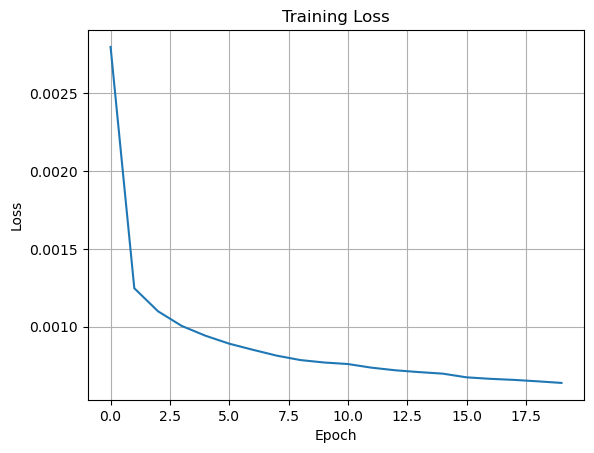

In [19]:
# train_loss plot
import matplotlib.pyplot as plt
plt.figure()
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.plot(range(len(train_loss)), train_loss)
plt.show()